# Field Failure Data Analysis

## Librerie

In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
from matplotlib import cm

# Reliability

from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF

# Utilities
import os
import numpy as np


ModuleNotFoundError: No module named 'pandas'

## Funzioni

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    print('Creazione del file', filepath, 'potrebbe richiedere del tempo...\n')
    tuples = []  # Lista per memorizzare il numero di tuple per ogni finestra

    for win in c_wins:
        tup = 1  # Inizializza il conteggio delle tuple a 1
        prev = int(dataframe.loc[0, 'Timestamp'])  # Timestamp del primo elemento nel dataframe

        for index in range(dataframe.shape[0] - 1):
            succ = int(dataframe.loc[index + 1, 'Timestamp'])  # Timestamp dell'elemento successivo
            if succ - prev >= win:  # Verifica se la differenza tra i timestamp soddisfa la finestra
                tup = tup + 1  # Incrementa il conteggio delle tuple
            prev = succ  # Aggiorna il timestamp precedente con quello successivo

        tuples.append(tup)  # Aggiunge il numero di tuple per la finestra corrente alla lista

    df_sens = pd.DataFrame(data={'Window': c_wins, 'Tuples': tuples})  # Crea un nuovo dataframe con le finestre e le tuple
    df_sens.to_csv(filepath)  # Salva il dataframe in un file CSV nel percorso specificato

    return df_sens  # Restituisce il dataframe risultante
    

In [3]:
def tupling(dataframe, c_win, filepath):
    print('Creazione del file', filepath, 'potrebbe richiedere del tempo...\n')
    
    tup = 0  # Contatore delle tuple
    prev = int(dataframe.loc[0, 'Timestamp'])  # Timestamp del primo elemento nel dataframe
    dataframe.loc[0, 'Tuple'] = 0  # Imposta il valore di Tuple per il primo elemento a 0

    for index in range(dataframe.shape[0] - 1):
        succ = int(dataframe.loc[index + 1, 'Timestamp'])  # Timestamp dell'elemento successivo
        if succ - prev >= c_win:  # Verifica se la differenza tra i timestamp soddisfa la finestra
            tup = tup + 1  # Incrementa il conteggio delle tuple
        dataframe.loc[index + 1, 'Tuple'] = tup  # Assegna il valore di tup a Tuple per l'elemento corrente
        prev = succ  # Aggiorna il timestamp precedente con quello successivo

    dataframe.to_csv(filepath)  # Salva il dataframe in un file CSV nel percorso specificato

    return dataframe  # Restituisce il dataframe risultante


In [4]:
def statistics(dataframe):
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])
    # Numero di elementi per ciascuna tupla
    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']
    # Start time per ciascuna tupla
    df_stat['Start time'] =  dataframe.groupby(by='Tuple').min(numeric_only=True)['Timestamp']
    # End time per ciascuna tupla
    df_stat['End time'] =  dataframe.groupby(by='Tuple').max(numeric_only=True)['Timestamp']
    # Calcolo della durata per ciascuna tupla
    df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
     # Calcolo della densità per ciascuna tupla
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
    # Calcolo dell'interarrivo tra le tuple
    df_temp = pd.concat([pd.DataFrame(data={'Start time': [np.nan]}), df_stat], ignore_index=True)
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
        
    return df_stat

## Caricamento BlueGeneL

In [5]:
# Legge il file di log 'BGLErrorLog.txt' come dataframe, assegnando i nomi alle colonne
# 'Timestamp', 'ID-Node', 'Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'.
# Specifica anche i tipi di dati per alcune colonne.
df_bgl = pd.read_csv('2_BlueGeneL/BGLErrorLog.txt', names=['Timestamp', 'ID-Node', 'Rack', 'Midplane', 'Node', 'Card', 'Card type', 'Message'], dtype={'Rack': object, 'Midplane': object}, low_memory=False)

# Estrapola l'ID del nodo dalla colonna 'Timestamp' e lo assegna alla colonna 'ID-Node'
df_bgl.loc[:, 'ID-Node'] = df_bgl.loc[:, 'Timestamp'].str.split(' ', n=3).str[1]

# Estrapola il numero del rack dall'ID del nodo e lo assegna alla colonna 'Rack'
df_bgl.loc[:, 'Rack'] = df_bgl.loc[:, 'ID-Node'].str.split('-', n=2).str[0]

# Estrapola il numero del midplane dall'ID del nodo e lo assegna alla colonna 'Midplane'
df_bgl.loc[:, 'Midplane'] = df_bgl.loc[:, 'ID-Node'].str.split('-', n=2).str[1]

# Estrapola il numero del nodo dall'ID del nodo e lo assegna alla colonna 'Node'
df_bgl.loc[:, 'Node'] = df_bgl.loc[:, 'ID-Node'].str.split('-', n=2).str[2]

# Estrapola il valore della carta dalla colonna 'Timestamp' e lo assegna alla colonna 'Card'
df_bgl.loc[:, 'Card'] = df_bgl.loc[:, 'Timestamp'].str.split(' ', n=3).str[2]

# Assegna il valore 'I-O' alla colonna 'Card type' per le righe in cui la colonna 'Card' contiene 'J18'
# Assegna il valore 'computation' alla colonna 'Card type' per le righe in cui la colonna 'Card' non contiene 'J18'
df_bgl.loc[df_bgl['Card'].str.contains('J18'), 'Card type'] = 'I-O'
df_bgl.loc[~df_bgl['Card'].str.contains('J18'), 'Card type'] = 'computation'

# Estrapola il messaggio dalla colonna 'Timestamp', rimuovendo spazi iniziali e finali, e lo assegna alla colonna 'Message'
df_bgl.loc[:, 'Message'] = df_bgl.loc[:, 'Timestamp'].str.split(' ', n=3).str[3].str.strip()

# Estrapola la data dalla colonna 'Timestamp' e sovrascrive la colonna 'Timestamp' con il valore estratto
df_bgl.loc[:, 'Timestamp'] = df_bgl.loc[:, 'Timestamp'].str.split(' ', n=3).str[0]

# Stampa il numero di righe e colonne del dataframe 'df_bgl'
print('Il file di log ha ' + str(df_bgl.shape[0]) + ' righe e ' + str(df_bgl.shape[1]) + ' colonne.')

# Visualizza le prime righe del dataframe 'df_bgl'
df_bgl.head()


Il file di log ha 125624 righe e 8 colonne.


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...


# Sistema (Blue Gene/L)

### Coalescenza Termporale

#### Analisi di Sensitività

In [6]:
# Legge il file 'tentative-Cwin.txt' e carica i dati nel DataFrame df_mercury_cwins.
# Assegna il nome di colonna 'Cwins'.
df_mercury_cwins = pd.read_table('2_BlueGeneL/tentative-Cwin.txt', names=['Cwins'])

# Stampa le prime righe del DataFrame df_mercury_cwins.
df_mercury_cwins.head()

,Cwins
0,10
1,50
2,100
3,120
4,150


Creazione del file 2_BlueGeneL/Coalescenza_Temporale/Csv/BlueGeneL-Sensitivity.csv potrebbe richiedere del tempo...



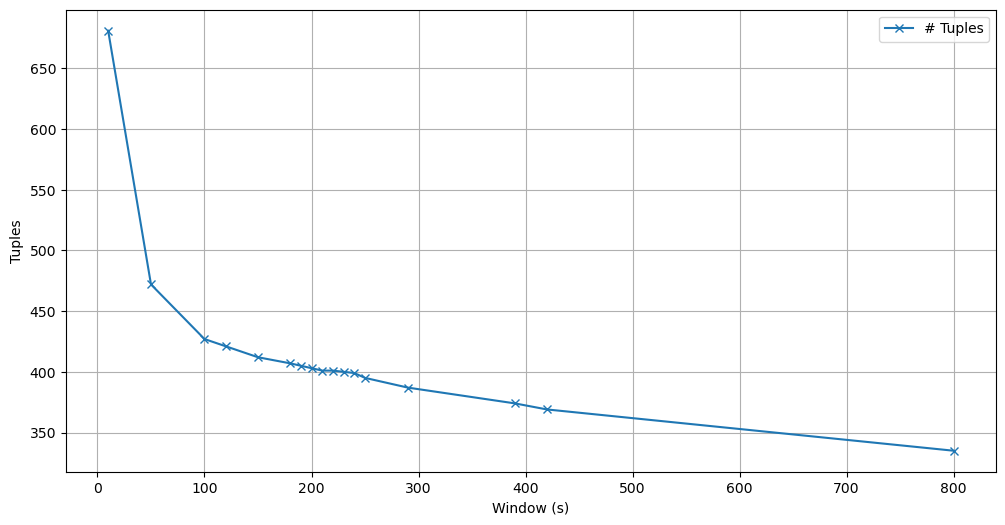

In [7]:


# Estrae i valori della colonna 'Cwins' dal DataFrame df_mercury_cwins e li assegna a c_wins.
c_wins = df_mercury_cwins['Cwins'].values

# Definisce il percorso del file CSV in cui verrà salvato il risultato dell'analisi di sensibilità.
filepath = '2_BlueGeneL/Coalescenza_Temporale/Csv/BlueGeneL-Sensitivity.csv'

df_bgl_sensitivity = sensitivity_analysis(df_bgl, c_wins, filepath)

plt.figure(figsize=(12,6))
plt.plot(df_bgl_sensitivity['Window'],df_bgl_sensitivity['Tuples'], label = '# Tuples',marker='x')
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_System_Sensitivity.png", format = "png")
plt.show()

#### Tupling

In [8]:
# Definisco la finestra di coalescenza con valore 200.
window = 200
# Definisce il percorso del file CSV in cui verranno salvate le tuple di BGL.
filepath = '2_BlueGeneL/Coalescenza_Temporale/Csv/BGL-Tuple.csv'
# Esegue la fase di tupling sul DataFrame df_bgl, utilizzando la finestra di coalescenza definita e il percorso del file CSV.
df_bgl = tupling(df_bgl, window, filepath)
# Converte le colonne 'Timestamp' e 'Tuple' del DataFrame df_mercury in tipo di dati int32.
df_bgl = df_bgl.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bgl.head()

Creazione del file 2_BlueGeneL/Coalescenza_Temporale/Csv/BGL-Tuple.csv potrebbe richiedere del tempo...



,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Message,Tuple
0,1128621350,R00-M0-N0,R00,M0,N0,J18-U01,I-O,Lustre mount FAILED : bglio2 : block_id : loca...,0
1,1128621350,R01-M1-N0,R01,M1,N0,J18-U11,I-O,Lustre mount FAILED : bglio21 : block_id : loc...,0
2,1128621351,R07-M0-NC,R07,M0,NC,J18-U01,I-O,Lustre mount FAILED : bglio124 : block_id : lo...,0
3,1128621351,R00-M0-N4,R00,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio4 : block_id : loca...,0
4,1128621351,R02-M0-N4,R02,M0,N4,J18-U01,I-O,Lustre mount FAILED : bglio36 : block_id : loc...,0


In [9]:
# Calcola il numero massimo di tuple presente nella colonna 'Tuple' del DataFrame df_bgl
num_tuple = df_bgl.max(axis = 0).loc['Tuple'] + 1
print('Numero di tuple: ', num_tuple)

Numero di tuple:  403


In [10]:
df_sys_stat = statistics(df_bgl)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,128,1128621350,1128621367,17,7.52941,NaN
1,1024,1128641281,1128641411,130,7.87692,19914
2,23,1128702415,1128702464,49,0.469388,61004
3,9,1128719240,1128719316,76,0.118421,16776
4,14,1128747957,1128748024,67,0.208955,28641


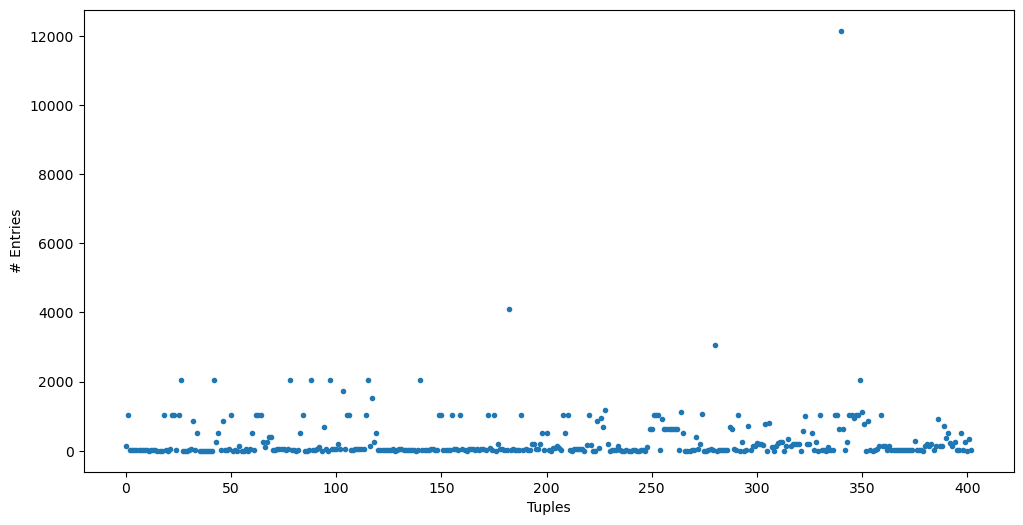

In [11]:
# Assegna gli indici del dataframe 'df_sys_stat' alla variabile x
x = df_sys_stat.index

# Assegna i valori della colonna '# Entries' del dataframe 'df_sys_stat' alla variabile y
y = df_sys_stat['# Entries']

# Trova gli indici delle righe con il numero massimo di '# Entries'
max_entries_indices = df_sys_stat[df_sys_stat['# Entries'] == df_sys_stat['# Entries'].max()].index

# Filtra il dataframe originale utilizzando gli indici delle righe con il numero massimo di '# Entries'
df_max_entries_range = df_sys_stat.loc[max_entries_indices]

# Aggiungi una colonna 'Riga Tupla' che contiene il numero di riga corrispondente
df_max_entries_range['Riga Tupla'] = df_max_entries_range.index

# Salva il dataframe filtrato nel file CSV "max_entries_range.csv" senza includere gli indici
df_max_entries_range.to_csv("2_BlueGeneL/Coalescenza_Temporale/Csv/max_entries_range.csv", index=False)

# Crea un grafico a dispersione con gli assi x e y
plt.figure(figsize=(12,6))
plt.scatter(x, y, marker='.')
plt.xlabel('Tuples')
plt.ylabel('# Entries')

# Salva il grafico come file immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_System_Scatter_Entry.png", format="png")

# Mostra il grafico
plt.show()


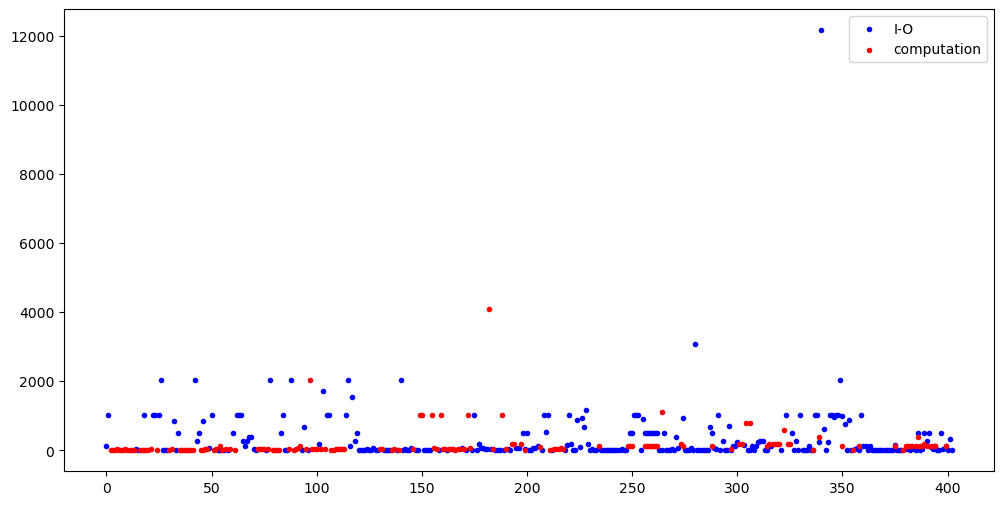

In [12]:
# Raggruppa il dataframe 'df_bgl' per le colonne 'Tuple' e 'Card type' e conta le occorrenze
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

# Crea una figura e un set di assi per il grafico con dimensioni specificate
fig, ax = plt.subplots(figsize=(12,6))

# Definisci i colori per i diversi tipi di carta
colors = ['blue', 'red']

# Per ogni tipo di carta presente nella colonna 'Card type' del dataframe 'df_bgl'
for i, card in enumerate(df_bgl['Card type'].unique()):
    # Seleziona solo le righe del dataframe raggruppato che corrispondono al tipo di carta corrente
    df_temp = df_group[df_group.index.get_level_values('Card type').isin([card])]
    
    # Estrapola gli indici di livello 0 dal dataframe temporaneo come coordinate x
    x = df_temp.index.get_level_values(0)
    
    # Estrapola i valori della colonna 'Timestamp' dal dataframe temporaneo come coordinate y
    y = df_temp['Timestamp']
    
    # Crea un grafico a dispersione utilizzando le coordinate x e y, con un'etichetta basata sul tipo di carta corrente e il colore specificato
    plt.scatter(x, y, label=card, marker='.', color=colors[i])

# Aggiungi una legenda al grafico
plt.legend()

# Salva il grafico come file immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_System_Scatter_CardType.png", format="png")

# Mostra il grafico
plt.show()



### Analisi dei troncamenti

In [13]:
# Calcola il quantile 0.1 della colonna 'Interarrival' del dataframe 'df_sys_stat' e assegna il valore alla variabile 'q'
q = df_sys_stat['Interarrival'].quantile(q=0.1)

# Stampa il valore del quantile 0.1
print("0.1 quantile: " + str(q))


0.1 quantile: 451.90000000000003


In [14]:
# Filtra il dataframe 'df_sys_stat' includendo solo le righe in cui il valore della colonna 'Interarrival' è minore o uguale al valore di 'q' (quantile 0.1)
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]

# Visualizza le prime righe del dataframe 'df_trunc'
df_trunc.head()


,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
11,1,1128868257,1128868257,0,inf,406
20,1,1129098173,1129098173,0,inf,397
29,1,1129223561,1129223561,0,inf,438
33,8,1129289944,1129289945,1,8,284
67,256,1129922826,1129922853,27,9.48148,320


In [15]:
num_trunc = df_trunc.shape[0]
perc_trunc = (num_trunc/num_tuple)*100

print('Troncamenti:', num_trunc)
print('Percentuale troncamenti:', perc_trunc)

Troncamenti: 41
Percentuale troncamenti: 10.173697270471465


### Analisi delle collisioni

In [16]:
# Raggruppa il dataframe 'df_bgl' per le colonne 'Tuple' e 'Rack' e conta le occorrenze di ogni gruppo
df_group = df_bgl.groupby(by=['Tuple','Rack']).count()

# Re-imposta l'indice del dataframe 'df_group' al secondo livello (livello 1)
df_group = df_group.reset_index(level=1)

# Inizializza la variabile 'collided' a 0, che conterà il numero di gruppi che hanno collisioni
collided = 0

# Itera sui valori unici dell'indice del dataframe 'df_group'
for tup in df_group.index.unique():
    # Verifica se ci sono più righe nel dataframe 'df_group' che corrispondono al valore dell'indice corrente
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        # Incrementa la variabile 'collided' se ci sono più righe, indicando che si è verificata una collisione
        collided = collided + 1


In [17]:
perc_coll = (collided/num_tuple)*100

print('Collisioni:', collided)
print('Percentuale Collisioni: ', perc_coll)

Collisioni: 185
Percentuale Collisioni:  45.90570719602978


In [18]:
# Raggruppa il dataframe 'df_bgl' per le colonne 'Tuple' e 'Card type' e conta le occorrenze
df_group = df_bgl.groupby(by=['Tuple','Card type']).count()

# Resetta l'indice di livello 1 del dataframe 'df_group'
df_group = df_group.reset_index(level=1)

# Inizializza la variabile 'collided' a 0 per contare il numero di gruppi che presentano collisioni
collided = 0

# Itera su tutti i valori unici dell'indice del dataframe 'df_group'
for tup in df_group.index.unique():
    # Seleziona le righe del dataframe 'df_group' corrispondenti all'indice 'tup'
    group = df_group.loc[df_group.index == tup]
    
    # Verifica se il numero di righe nel gruppo è maggiore di 1, indicando una collisione
    if group.shape[0] > 1:
        collided = collided + 1


In [19]:
perc_coll = (collided/num_tuple)*100

print('Collisioni:', collided)
print('Percentuale Collisioni: ', perc_coll)

Collisioni: 39
Percentuale Collisioni:  9.67741935483871


## Analisi da fare su matlab

### Distribuzione empirica del tempo fino al Faulire

### Empirical reliability

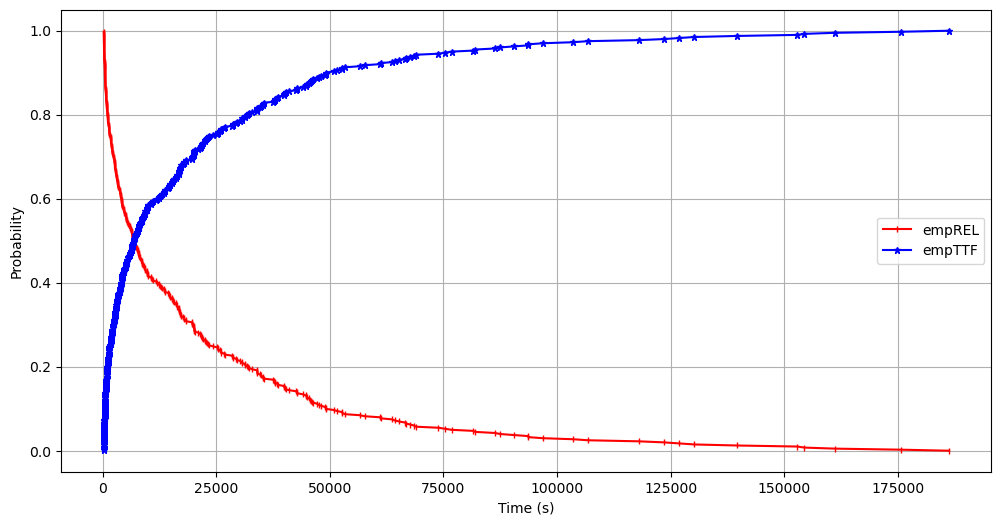

In [20]:
# Crea un array numpy 'data_bgl' con i valori non nulli della colonna 'Interarrival' del dataframe 'df_sys_stat'
data_bgl = df_sys_stat['Interarrival'].dropna().to_numpy()

# Calcola la cumulative distribution function empirica (ECDF) dei dati 'data_bgl'
ecdf = ECDF(data_bgl)

# Crea una nuova figura con dimensioni specificate
plt.figure(figsize=(12, 6))

# Traccia il grafico dell'affidabilità empirica in rosso utilizzando il simbolo '|' come marker
plt.plot(ecdf.x, 1 - ecdf.y, color='red', marker='|', markersize=5, label='empREL')

# Traccia il grafico del tempo medio fino al fallimento (empirical Time-To-Failure, TTF) in viola utilizzando il simbolo '*' come marker
plt.plot(ecdf.x, ecdf.y, color='blue', marker='*', markersize=5, label='empTTF')

plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("2_BlueGeneL/BGL_System_Emp_Reliability.png", format = "png")
plt.show()

### Analisi Generale

In [21]:
print('Messaggi di errore distinti:', df_bgl.groupby(by='Message').count().shape[0])

Messaggi di errore distinti: 25712


In [22]:
# Inserisce una nuova colonna chiamata 'Message type' nel dataframe 'df_bgl' con valori NaN
df_bgl.insert(len(df_bgl.columns), 'Message type', np.NaN)


In [23]:
# Assegna il valore 'NET' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'socket' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('socket') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'

# Assegna il valore 'NET' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'packet' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('packet') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'

# Assegna il valore 'FS' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'Lustre mount' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('Lustre mount') & df_bgl['Message type'].isnull(), 'Message type'] = 'FS'

# Assegna il valore 'CACHE' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'cache' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('cache') & df_bgl['Message type'].isnull(), 'Message type'] = 'CACHE'

# Assegna il valore 'MEM' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'program image' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('program image') & df_bgl['Message type'].isnull(), 'Message type'] = 'MEM'

# Assegna il valore 'FS' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'directory' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('directory') & df_bgl['Message type'].isnull(), 'Message type'] = 'FS'

# Assegna il valore 'NET' alla colonna 'Message type' del dataframe 'df_bgl' per le righe in cui il testo 'link' è presente nella colonna 'Message' e 'Message type' è NaN
df_bgl.loc[df_bgl.Message.str.contains('link') & df_bgl['Message type'].isnull(), 'Message type'] = 'NET'


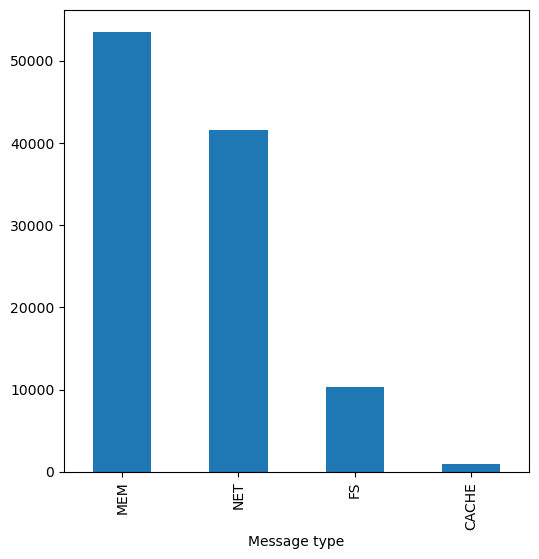

In [24]:
# Raggruppa il dataframe 'df_bgl' in base alla colonna 'Message type' e conta il numero di occorrenze di 'Timestamp' per ogni gruppo. Quindi ordina i risultati in ordine discendente.
count_by_message_type = df_bgl.groupby(by='Message type').Timestamp.count().sort_values(ascending=False)

# Traccia un grafico a barre dei conteggi ottenuti, utilizzando la dimensione della figura 6x6.
count_by_message_type.plot.bar(figsize=(6, 6))

# Salva il grafico a barre sul file PNG specificato.
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_System_Bar_Message.png", format="png")

# Mostra il grafico a barre.
plt.show()


In [25]:
# Seleziona le righe del dataframe 'df_bgl' in cui il testo 'kernel' è presente nella colonna 'Message'
# Raggruppa le righe filtrate in base alla colonna 'Message' e conta il numero di occorrenze per ogni valore di 'Message'
df_bgl.loc[df_bgl.Message.str.contains('kernel')].groupby('Message').count()


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Tuple,Message type
Message,,,,,,,,,
ciod: Error loading /bgl/apps/SWL/functional/SYS_CALLS/testcases/kernel/syscalls/open/dup201: invalid or missing program image,8,8,8,8,8,8,8,8,8
ciod: Error loading /p/gb1/bwallen/oldcode_newkernel.rts: invalid or missing program image,1024,1024,1024,1024,1024,1024,1024,1024,1024
kernel panic,6,6,6,6,6,6,6,6,0
rts: kernel terminated for reason 1004,6144,6144,6144,6144,6144,6144,6144,6144,0
rts: kernel terminated for reason 1007,7,7,7,7,7,7,7,7,0


In [26]:
# Filtra il dataframe 'df_bgl' selezionando le righe in cui il testo nella colonna 'Message' non corrisponde ai pattern specificati: '^[0-9]:', '^[0-9][0-9]:', '^0x'
# Raggruppa il dataframe filtrato 'df_filter' in base alla colonna 'Message' e conta il numero di occorrenze per ogni valore di 'Message'
# Ordina i risultati in ordine discendente basandosi sul conteggio delle occorrenze della colonna 'Timestamp'
# Seleziona le prime 10 righe dei risultati ordinati
df_filter = df_bgl.loc[~df_bgl.Message.str.contains('^[0-9]:|^[0-9][0-9]:|^0x')]
df_filter.groupby(by='Message').count().sort_values(by='Timestamp', ascending=False).head(10)


,Timestamp,ID-Node,Rack,Midplane,Node,Card,Card type,Tuple,Message type
Message,,,,,,,,,
Error receiving packet on tree network,6145,6145,6145,6145,6145,6145,6145,6145,6145
rts: kernel terminated for reason 1004,6144,6144,6144,6144,6144,6144,6144,6144,0
ciod: LOGIN chdir(/g/g0/spelce1/Linpack_SWL) failed: No such file or directory,3071,3071,3071,3071,3071,3071,3071,3071,3071
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/fft_only.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /bgl/apps/followup/RAPTOR/pre-study/raptor.newcomp.r1: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /g/g0/spelce1/Tuned/SPaSM-base/rundir/SPaSM.baseline: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/vnm.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: Error loading /home/spelce1/HPCC_IBM/Urgent/COP/64K/EPStreamTriad.64K.rts: invalid or missing program image,2048,2048,2048,2048,2048,2048,2048,2048,2048
ciod: LOGIN chdir(RUNS/3Bvn_fmm/rs0000) failed: No such file or directory,1920,1920,1920,1920,1920,1920,1920,1920,1920


# Top Racks

In [27]:
print('Numero di rack che generano errori: ' + str(len(df_bgl['Rack'].unique())))

Numero di rack che generano errori: 64


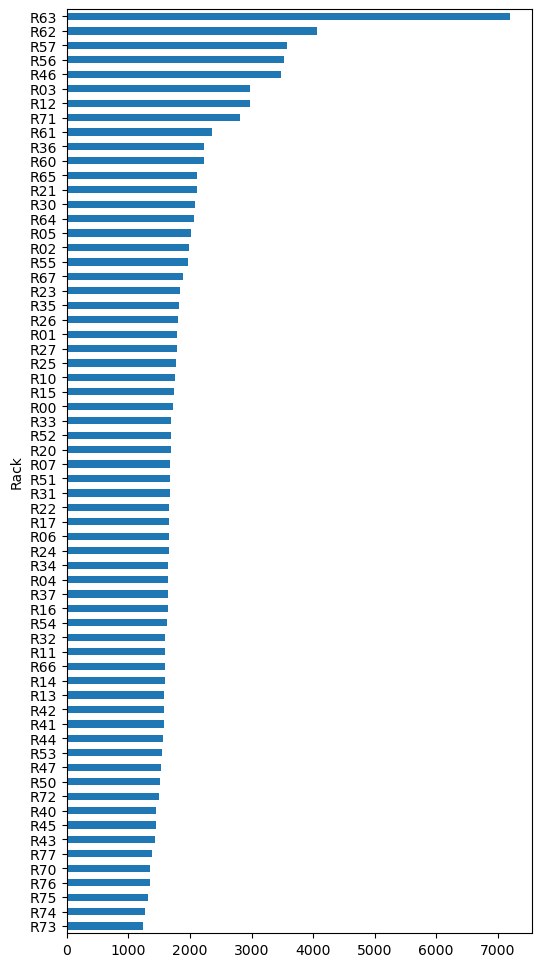

In [28]:
plt.figure(figsize=(6,12))
# Raggruppa il dataframe 'df_bgl' in base alla colonna 'Rack' e conta il numero di occorrenze per ogni valore di 'Rack'
grouped_counts = df_bgl.groupby(by='Rack').Timestamp.count()

# Ordina i risultati in base al conteggio delle occorrenze e traccia un grafico a barre orizzontali
grouped_counts.sort_values().plot.barh()

# Salva il grafico in un file immagine
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_System_Bar_Rack.png", format="png")

# Mostra il grafico
plt.show()
plt.show()

Il sistema è fatto da 64 rack e gli errori sono distribuiti come nella figura sopra.
sotto si estraggono gli n rack con piu falliemnti, per fare analisi per i rack piu problematici.

In [29]:
# Imposta il numero desiderato di top rack da selezionare
n = 8

# Trova i top rack selezionando i primi 'n' rack con il numero maggiore di occorrenze, ordinati in ordine decrescente
top_rack = df_bgl.groupby(by=['Rack']).Timestamp.count().sort_values(ascending=False)[0:n].index

# Crea un nuovo DataFrame df_top_rack che contiene solo le righe del DataFrame originale df_bgl corrispondenti ai top rack
df_top_rack = pd.concat([df_bgl[df_bgl['Rack'] == rack] for rack in top_rack])

# Stampa il numero di righe e colonne presenti nel DataFrame df_top_rack utilizzando il metodo 'shape'
print('Il DataFrame ha ' + str(df_top_rack.shape[0]) + ' righe e ' + str(df_top_rack.shape[1]) + ' colonne.')


df_top_rack.head()



Il DataFrame ha 30615 righe e 10 colonne.


,Timestamp,ID-Node,Rack,Midplane,...,Card type,Message,Tuple,Message type
356,1128641308,R63-M1-NC,R63,M1,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
357,1128641308,R63-M1-NC,R63,M1,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
400,1128641312,R63-M0-N0,R63,M0,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
401,1128641312,R63-M0-N0,R63,M0,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
414,1128641314,R63-M0-NC,R63,M0,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET


<Figure size 600x600 with 0 Axes>

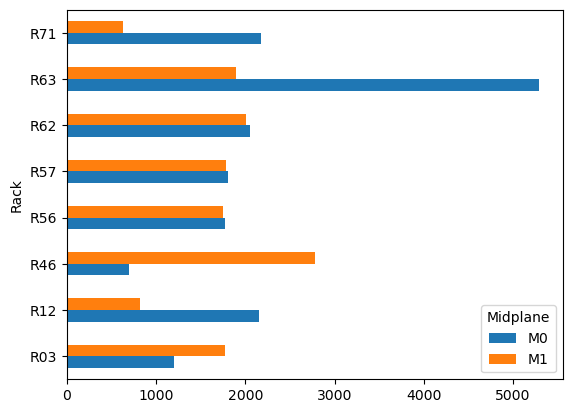

In [30]:

# Calcola il conteggio delle occorrenze di Timestamp raggruppate per Rack e Midplane nel DataFrame df_top_rack
occurrences = df_top_rack.groupby(by=['Rack', 'Midplane']).Timestamp.count()

# Trasforma i dati in una matrice con Rack come indice e Midplane come colonne utilizzando il metodo unstack(1)
occurrences_matrix = occurrences.unstack(1)

# Genera un grafico a barre orizzontali per visualizzare le occorrenze dei Rack e Midplane
plt.figure(figsize=(6, 6))
occurrences_matrix.plot.barh()

# Salva il grafico come file immagine nel formato PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Rack_Bar_Rack_Midplane.png", format="png")


plt.show()


ogni rack ha 2 midplane. gli errori trai midplane sono piu o meno bilanciati tranne qualcuno.
il 63 a differenza degli altri ha un midplain spopositato

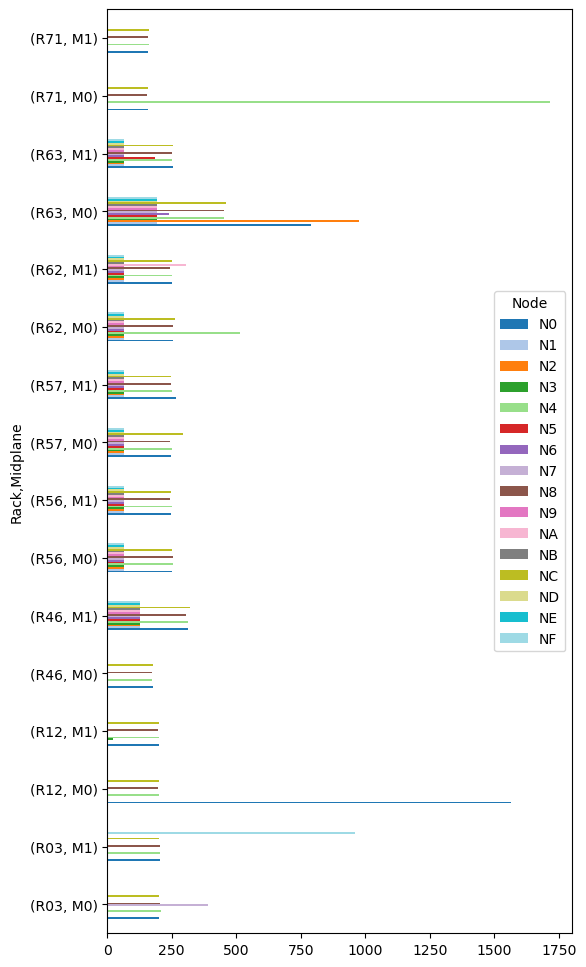

In [31]:
# Calcola il conteggio delle occorrenze di Timestamp raggruppate per Rack, Midplane e Node nel DataFrame df_top_rack
# Trasforma i dati in una matrice con Rack e Midplane come indice e Node come colonne utilizzando il metodo unstack(2)
# Genera un grafico a barre orizzontali per visualizzare le occorrenze dei Rack, Midplane e Node
df_top_rack.groupby(by=['Rack', 'Midplane', 'Node']).Timestamp.count().unstack(2).plot.barh(figsize=(6,12), cmap = 'tab20')

# Salva il grafico come file immagine nel formato PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Rack_Bar_Rack_Midplane_Node.png", format="png")

# Mostra il grafico
plt.show()





 Si nota che:
- r63 fa pena, non c è un singolo nodo che si sputtana
- r71 ha il nodo con piu fallimenti di tutto il sistema,un N4 che fa IO
- r12 pure, sempre un nodo di IO (N0)
- r03 pure esplode un nodo di computation
- tutti i nodi hanno errori sui 4 nodi che hanno scheda di IO (azzurro n0 verde n4 marrone n8 ocra nC)

# Card Types

In [32]:
# Estrae i valori unici dalla colonna 'Card type' del DataFrame df_bgl
types = df_bgl['Card type'].unique()


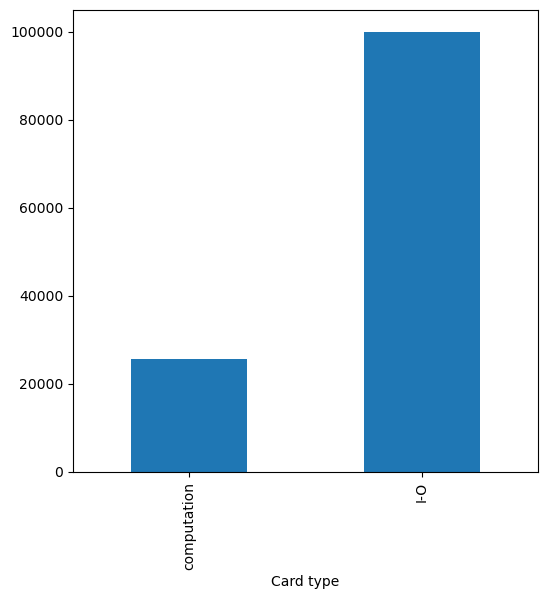

In [33]:

plt.figure(figsize=(6,6))

# Raggruppa il DataFrame df_bgl per 'Card type' e conta il numero di occorrenze nella colonna 'Timestamp'
# Quindi, ordina i risultati in base al conteggio e traccia un grafico a barre
df_bgl.groupby(by='Card type').Timestamp.count().sort_values().plot.bar(figsize=(6,6))

# Salva il grafico a barre come immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Card_Bar_Type.png", format = "png")


plt.show()


sopra si vede che fondamentamente ci sono problemi con il sistema di IO.

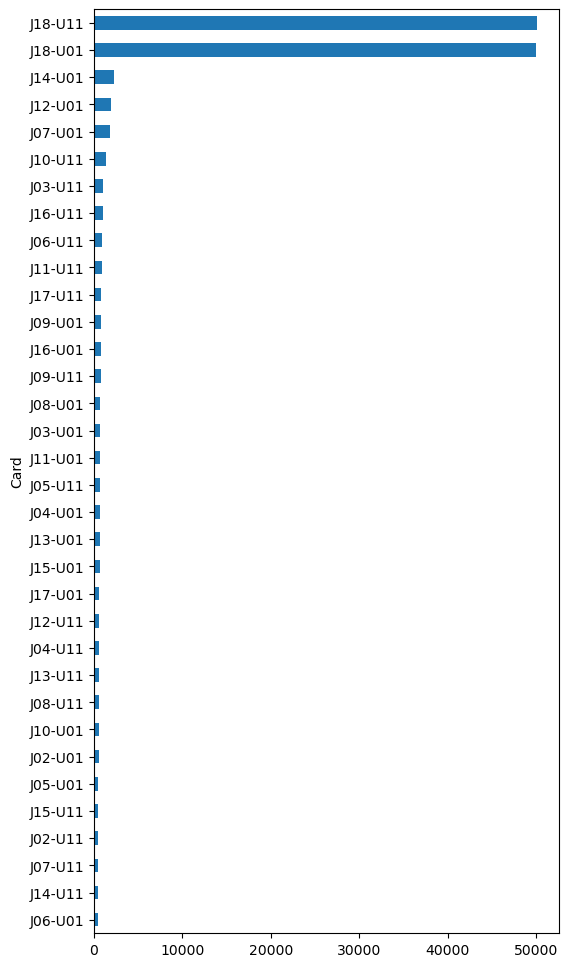

In [34]:

plt.figure(figsize=(6,12))

# Raggruppa il DataFrame df_bgl per 'Card' e conta il numero di occorrenze nella colonna 'Timestamp'
# Quindi, ordina i risultati in base al conteggio e traccia un grafico a barre orizzontale
df_bgl.groupby(by='Card').Timestamp.count().sort_values().plot.barh(figsize=(6,12))

# Salva il grafico a barre orizzontale come immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Card_Bar_Node.png", format = "png")


plt.show()


gli errori sono bilanciati tra le due card di ogni tipologia.

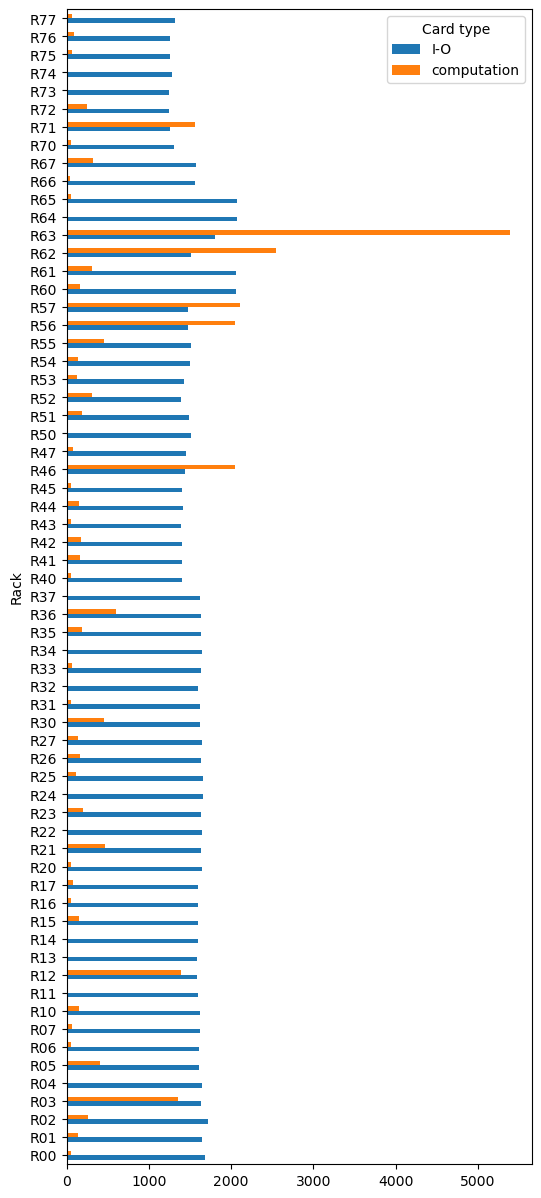

In [35]:
# Raggruppa il DataFrame df_bgl per le colonne 'Rack' e 'Card type', conta il numero di occorrenze nella colonna 'Timestamp'
# e crea una tabella pivot in cui le colonne corrispondono ai diversi valori di 'Card type'
# Quindi, traccia un grafico a barre orizzontale della tabella pivot
df_bgl.groupby(by=['Rack','Card type']).Timestamp.count().unstack(1).plot.barh(figsize=(6,15))

# Salva il grafico a barre orizzontale come immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Card_Bar_Rack_Type.png", format = "png")


plt.show()


da questa immagine vediamo che i problemi di IO sono comuni a quasi tutti i rack.
un altro fatto interessante è che i rack più critici non hanno solo problemi con l'IO ma anche  con le card di computation

# Top Nodes

In [36]:
# Stampa il numero di nodi unici che generano errori nel DataFrame df_bgl
print('Numero di nodi che generano errori: ' + str(len(df_bgl['ID-Node'].unique())))


Numero di nodi che generano errori: 698


In [37]:
n = 5

# Calcola i top n nodi con il numero maggiore di errori nel DataFrame df_bgl
top_node = df_bgl.groupby(by=['ID-Node']).Timestamp.count().sort_values(ascending=False)[0:n].index

# Crea un nuovo DataFrame df_top_node che contiene solo le righe corrispondenti ai top n nodi
df_top_node = pd.concat([df_bgl[df_bgl['ID-Node'] == node] for node in top_node])

# Stampa il numero di righe e colonne presenti nel DataFrame df_top_node
print('Il DataFrame df_top_node ha ' + str(df_top_node.shape[0]) + ' righe e ' + str(df_top_node.shape[1]) + ' colonne.')

# Stampa le prime righe del DataFrame df_top_node
df_top_node.head()


Il DataFrame df_top_node ha 6006 righe e 10 colonne.


,Timestamp,ID-Node,Rack,Midplane,...,Card type,Message,Tuple,Message type
1006,1128641385,R71-M0-N4,R71,M0,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
1007,1128641385,R71-M0-N4,R71,M0,...,I-O,ciod: Error reading message prefix after LOGIN...,1,NET
2298,1128970796,R71-M0-N4,R71,M0,...,I-O,ciod: Error reading message prefix after LOAD_...,18,NET
2299,1128970796,R71-M0-N4,R71,M0,...,I-O,ciod: Error reading message prefix after LOAD_...,18,NET
3289,1129165930,R71-M0-N4,R71,M0,...,I-O,ciod: Error loading /home/spelce1/HPCC_IBM/Urg...,22,MEM


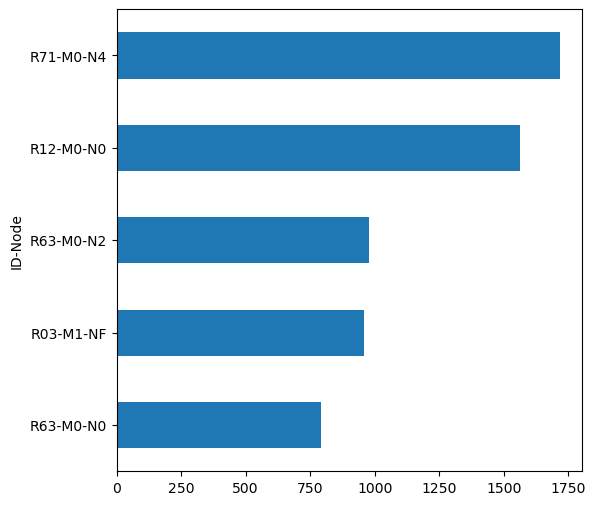

In [38]:
# Raggruppa il DataFrame df_top_node per 'ID-Node' e conta il numero di occorrenze di 'Timestamp' per ciascun nodo
node_counts = df_top_node.groupby(by='ID-Node').Timestamp.count()

# Crea un grafico a barre orizzontali con i conteggi dei nodi
plt.figure(figsize=(6, 6))
node_counts.sort_values(ascending=True).plot.barh()

# Salva il grafico come immagine PNG
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/BGL_Node_Bar.png", format="png")

# Mostra il grafico
plt.show()


## Mercury vs Blue Gene/L

Creazione del file 1_Mercury/Mercury-Data.csv potrebbe richiedere del tempo...



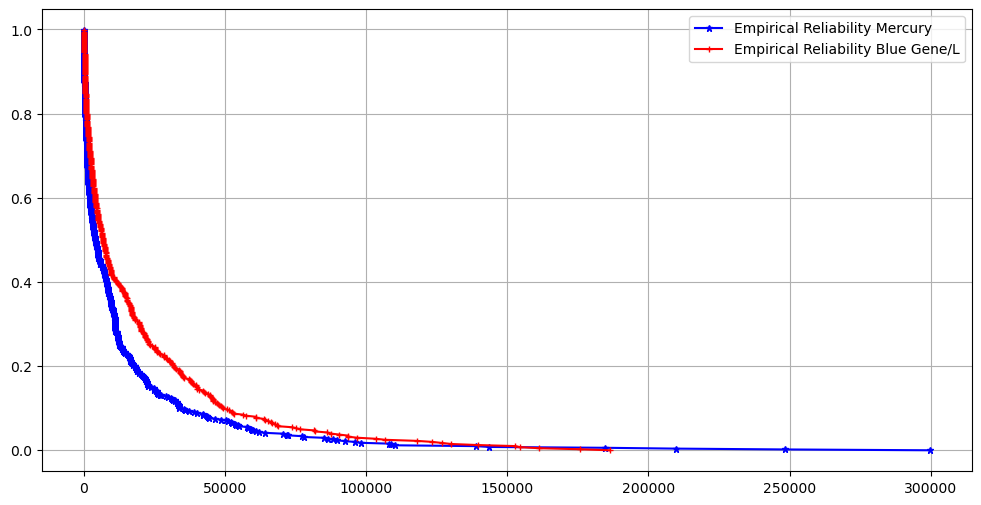

In [39]:
# Legge il file di log 'MercuryErrorLog.txt' e lo carica nel DataFrame df_mercury.
# Assegna i nomi di colonna 'Timestamp', 'Node', 'Subsystem' e 'Message'.
df_mercury = pd.read_table('1_Mercury/MercuryErrorLog.txt', names=['Timestamp', 'Node', 'Subsystem', 'Message'])

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Node'.
df_mercury.loc[:, 'Node'] = df_mercury['Timestamp'].str.split(' ', n=3).str[1]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Subsystem'.
df_mercury.loc[:, 'Subsystem'] = df_mercury['Timestamp'].str.split(' ', n=3).str[2]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Message'.
df_mercury.loc[:, 'Message'] = df_mercury['Timestamp'].str.split(' ', n=3).str[3]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Timestamp' corretto.
df_mercury.loc[:, 'Timestamp'] = df_mercury['Timestamp'].str.split(' ', n=3).str[0]

# Assegna un valore 'Type' basato sul contenuto della colonna 'Node'.
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'


window = 200

filepath = '1_Mercury/Mercury-Data.csv'

df_mercury = tupling(df_mercury, window, filepath)
df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})

df_sys_stat = statistics(df_mercury)


data = df_sys_stat['Interarrival'].dropna().to_numpy()

ecdf = ECDF(data)
ecdf_bgl = ECDF(data_bgl)

plt.figure(figsize=(12,6))
    
plt.plot(ecdf.x, 1-ecdf.y,color='blue', marker='*',markersize=5, label = 'Empirical Reliability Mercury')
plt.plot(ecdf_bgl.x, 1-ecdf_bgl.y,color='red', marker='+',markersize=5, label = 'Empirical Reliability Blue Gene/L')


plt.legend()
plt.grid()
plt.savefig("2_BlueGeneL/Coalescenza_Temporale/immagini/Mercury_BGL_Comparison.png", format = "png")
plt.show()